In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import os

In [2]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

MODEL_DIR = Path.cwd()

In [3]:
df = pd.read_csv(DATA_DIR / "dataset_sat_images.csv")
df.head()

,uid,latitude,longitude,date,split,region,severity,density,image_src
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,sentinel
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,sentinel
2,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0,no_image
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0,sentinel
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0,sentinel


In [4]:
# remove id's where no sat images could be collected
print("Initial entries in dataset: ", len(df))
errored_ids = ['einx', 'gygq', 'ifwc', 'jdvp', 'qpeh', 'tgiq', 'wrqa']
for id in errored_ids:
    df.drop(df.loc[df['uid']==id].index, inplace=True)
print("Remaining entries in dataset: ", len(df))
image_count = len(df)

Initial entries in dataset:  17060
Remaining entries in dataset:  17053


In [5]:
# add filepaths to dataframe
def get_path(id):
   return str(DATA_DIR/'sat_images/image_arrays_8_layer_2/') + f"/{id}.npy"

df['path'] = df["uid"].apply(get_path)

pd.set_option('display.max_colwidth', None)
df.head(5)

,uid,latitude,longitude,date,split,region,severity,density,image_src,path
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aabm.npy
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aacd.npy
2,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0,no_image,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaee.npy
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaff.npy
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aafl.npy


In [6]:
example_row = df[df.uid == "aabm"].iloc[0]
example_row

uid                                                                                              aabm
latitude                                                                                    39.080319
longitude                                                                                  -86.430867
date                                                                                       2018-05-14
split                                                                                           train
region                                                                                        midwest
severity                                                                                            1
density                                                                                         585.0
image_src                                                                                    sentinel
path         /Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays

## Extract features from satellite image files

In [7]:
def get_image_features(image_layers):
    # count water pixels
    num_water_pxl = (image_layers[4] > 0.0).sum()
    # calculate mean color values from masked (water-only) layers
    mean_r  = image_layers[4].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_g  = image_layers[5].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_b  = image_layers[6].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_ir = image_layers[7].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    
    # calculate HSV transformed image from water-only layers
    rgb = np.array([image_layers[4],image_layers[5],image_layers[6]])
    hsv = np.transpose(cv2.cvtColor(np.transpose((rgb), axes=[1, 2, 0]), cv2.COLOR_RGB2HSV), axes=[2, 0, 1])

    # calculate mean values for hue, saturation and value (hue is scaled from 360° into 0...1 range)
    mean_h  = hsv[0].sum()/(num_water_pxl*360) if (num_water_pxl > 0) else 0.0
    mean_s  = hsv[1].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0
    mean_v  = hsv[2].sum()/(num_water_pxl) if (num_water_pxl > 0) else 0.0

    features = {'lake_size': num_water_pxl,
                'mean_r': mean_r, 
                'mean_g': mean_g, 
                'mean_b': mean_b, 
                'mean_ir': mean_ir, 
                'mean_h': mean_h,
                'mean_s': mean_s,
                'mean_v': mean_v}

    return features

In [8]:
image_layers = np.load(example_row.path)
features = get_image_features(image_layers)
features

{'lake_size': 2578,
 'mean_r': 0.467581288032147,
 'mean_g': 0.6074859406062112,
 'mean_b': 0.5362475907922808,
 'mean_ir': 0.42440888232459756,
 'mean_h': 0.41378191400525816,
 'mean_s': 0.2341533983465865,
 'mean_v': 0.6078412608641631}

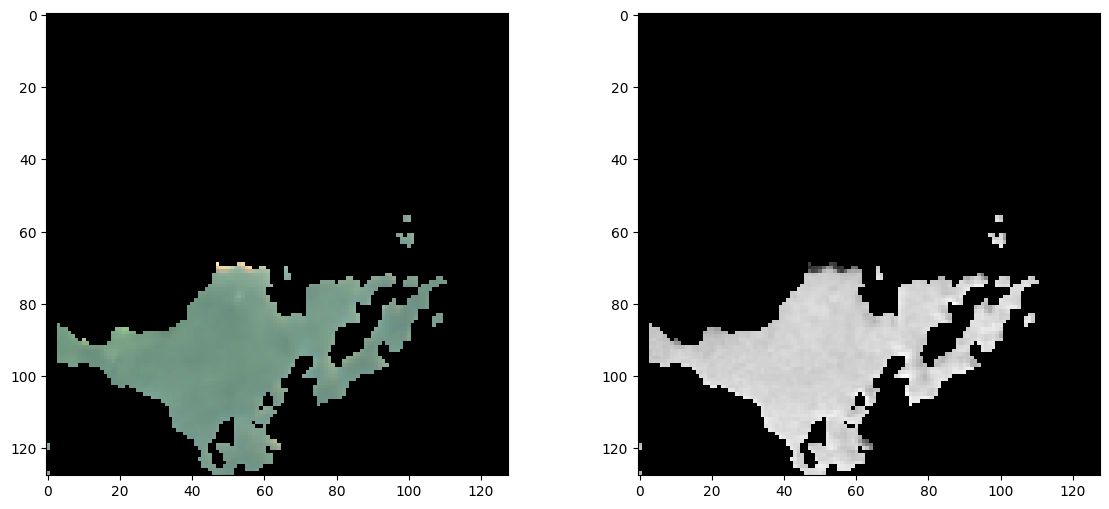

In [9]:
# show loaded image and hsv conversion
rgb = np.array([image_layers[4],image_layers[5],image_layers[6]])
hsv = np.transpose(cv2.cvtColor(np.transpose((rgb), axes=[1, 2, 0]), cv2.COLOR_RGB2HSV), axes=[2, 0, 1])

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.transpose((rgb), axes=[1, 2, 0]))
plt.subplot(122)
# plot hsv image (will be false colors)
#plt.imshow(np.transpose((hsv), axes=[1, 2, 0]));
# or plot only hue layer
plt.imshow(hsv[0], cmap='gray');

### Ectract features for all images

In [10]:
# use only part of the dataset where images were found
image_df = df[df['image_src'] != 'no_image']
image_df

,uid,latitude,longitude,date,split,region,severity,density,image_src,path
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aabm.npy
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aacd.npy
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaff.npy
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aafl.npy
8,aaia,35.980000,-78.791686,2018-06-27,train,south,1,16943.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/aaia.npy
...,...,...,...,...,...,...,...,...,...,...
17052,zzqy,37.928600,-121.561000,2018-05-15,train,west,4,5548841.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzqy.npy
17054,zzry,38.256057,-86.776403,2021-07-19,train,midwest,2,63056.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzry.npy
17055,zzsv,38.707825,-75.080867,2018-06-27,train,south,3,113125.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzsv.npy
17057,zzwo,39.792190,-99.971050,2017-06-19,train,midwest,2,48510.0,sentinel,/Users/markus/neuefische/tick-tick-bloom/data/sat_images/image_arrays_8_layer_2/zzwo.npy


In [11]:
# extract features from all images
for row in tqdm(image_df.itertuples(), total=len(image_df)):
    # load image file
    image_layers = np.load(row.path)

    # extract features
    features = get_image_features(image_layers)

    # add features to dataframe
    df.loc[df['uid'] == row.uid, ['lake_size']] = features['lake_size']
    df.loc[df['uid'] == row.uid, ['mean_r']] = features['mean_r']
    df.loc[df['uid'] == row.uid, ['mean_g']] = features['mean_g']
    df.loc[df['uid'] == row.uid, ['mean_b']] = features['mean_b']
    df.loc[df['uid'] == row.uid, ['mean_ir']] = features['mean_ir']
    df.loc[df['uid'] == row.uid, ['mean_h']] = features['mean_h']
    df.loc[df['uid'] == row.uid, ['mean_s']] = features['mean_s']
    df.loc[df['uid'] == row.uid, ['mean_v']] = features['mean_v']


100%|██████████| 6176/6176 [00:49<00:00, 124.16it/s]


In [12]:
df = df.drop('path', axis=1)

In [13]:
df.head(10)

,uid,latitude,longitude,date,split,region,severity,density,image_src,lake_size,mean_r,mean_g,mean_b,mean_ir,mean_h,mean_s,mean_v
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,sentinel,2578.0,0.467581,0.607486,0.536248,0.424409,0.413782,0.234153,0.607841
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,sentinel,176.0,0.112471,0.111118,0.057916,0.059888,0.163396,0.503357,0.115065
2,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest,3,111825.0,sentinel,1495.0,0.065787,0.085121,0.044582,0.020998,0.245394,0.480389,0.085137
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest,4,2017313.0,sentinel,8045.0,0.166186,0.276183,0.181284,0.127355,0.356467,0.412104,0.276187
5,aafp,35.647742,-79.271782,2017-11-15,train,south,1,1594.0,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,aagm,35.906885,-79.132962,2020-06-10,train,south,1,3873.0,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,aahy,35.726522,-79.125458,2014-08-12,train,south,1,6100.0,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,aaia,35.980000,-78.791686,2018-06-27,train,south,1,16943.0,sentinel,3.0,0.208500,0.298184,0.261890,0.232462,0.432910,0.302307,0.298184
9,aaie,35.861325,-78.768321,2013-11-06,train,south,2,22822.0,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df.to_csv(DATA_DIR / "dataset_img_features.csv", index=False)

## Modeling

In [15]:
# Clear any logs from previous runs
#!rm -rf ./logs/